## Import Libraries

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data Import & Initial Munging
* Data was pulled from the bigquery pushshift.io dataset via SQL, with author, subreddit and count of number of posts from 2018
* Full SQL query:
    * SELECT author, subreddit, count(subreddit) FROM [fh-bigquery.reddit_posts.2018_12] WHERE author != "[deleted]" AND subreddit IS NOT NULL GROUP BY author, subreddit
* Included all months for 2018 within SQL query


In [37]:
#import data, 3 files with all 2018 posts split into between
raw_data_1 = pd.read_csv('/Users/samholt/GA/Capstone_Data_MKII/Capstone_MKII_Data_1.csv', sep = ",")
raw_data_2 = pd.read_csv('/Users/samholt/GA/Capstone_Data_MKII/Capstone_MKII_Data_2.csv', sep = ",")
raw_data_3 = pd.read_csv('/Users/samholt/GA/Capstone_Data_MKII/Capstone_MKII_Data_3.csv', sep = ",")

In [38]:
# merge dataframe
df_first = pd.merge(raw_data_1, raw_data_2, on=["author", "subreddit"], how= "outer" )
df= pd.merge(raw_data_3, df_first, on=["author", "subreddit"], how= "outer" )

In [39]:
#  checking to see how the merge has gone, need to deal with null values
df.head()

,author,subreddit,f0_,f0__x,f0__y
0,businessbrand121,business,8.000000,nan,nan
1,GenericManChild,starbound,9.000000,1.000000,1.000000
2,AutoModerator,AroundTheNFL,9.000000,8.000000,9.000000
3,sleepinzombie,iphone,8.000000,1.000000,nan
4,switchnbitch,GonewildAudible,8.000000,nan,7.000000


In [40]:
#dealing with null values with 0 as they mean a user hasn't posted to that subreddit in one of the three periods
df.fillna(0, inplace= True)

In [41]:
# create one variable with overall count of posts per subreddit per user
df["posts"] = df["f0_"] + df["f0__x"] + df["f0__y"]

In [42]:
#drop the remaining variables
df.drop(labels= ['f0_', 'f0__x', 'f0__y'], inplace= True, axis= 1)

In [43]:
#check for null values, 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40347434 entries, 0 to 40347433
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   author     object 
 1   subreddit  object 
 2   posts      float64
dtypes: float64(1), object(2)
memory usage: 1.2+ GB


In [44]:
df.shape

(40347434, 3)

In [45]:
num_authors = len(df["author"].unique())
num_subreddits = len(df["subreddit"].unique())
num_posts = df["posts"].sum()

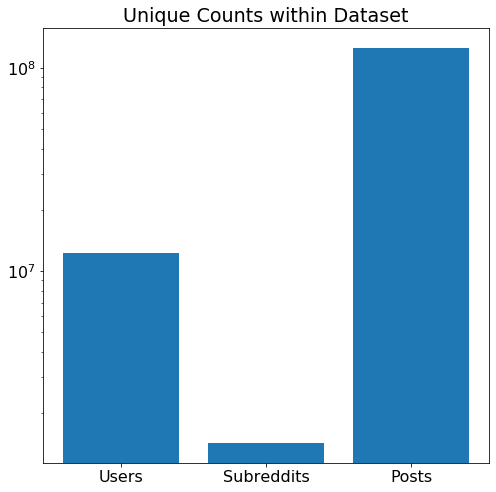

In [46]:
labels = [num_authors, num_subreddits, num_posts]
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize = (8, 8))
plt.bar(x = ["Users", "Subreddits", "Posts"], height= labels, log = True)
plt.title("Unique Counts within Dataset")
plt.show()

## Data Cleaning Steps
* Converting authors to numerical key, saves memory & not interested in specific users
* Dealing with outliers in number of posts per user
* Understanding subreddit usage per user & removing those with limited information (number of subreddits posted to)
* Creating target variable
    * Boolean for whether a user posted to list of mental health related subreddits
* Merging single user subreddits and those with a small number of users in to one variable

#### Convert Authors to Numerical Key
* As we don't want to delve into individual tastes, and to save on any issues with memory converting authors to a numerical key

In [47]:
# get list of unique authors
authors = df["author"].unique()
len(authors)

12196808

In [48]:
# creating dictionary in order to assign numerical value per author
authors_dict = {}
counter = 0
for i in authors:
    authors_dict[i] = counter
    counter +=1

In [49]:
# replace authors with created numerical key
df["author"] = [authors_dict[i] for i in df["author"]]

#### Checking for outliers
* Visualisation of the data shows a number of outliers in terms of number of posts per user; high posters were often bots or spam and were removed

In [50]:
# every user has posted at least once to a specific subreddit, though seem to be a curiously high number of posts in some instances
pd.set_option('float_format', '{:f}'.format)
df.describe()

,author,posts
count,40347434.000000,40347434.000000
mean,4137176.743367,3.102450
std,3368923.448197,420.571889
min,0.000000,1.000000
25%,1122532.000000,1.000000
50%,3310141.000000,1.000000
75%,6514580.750000,2.000000
max,12196807.000000,2243748.000000


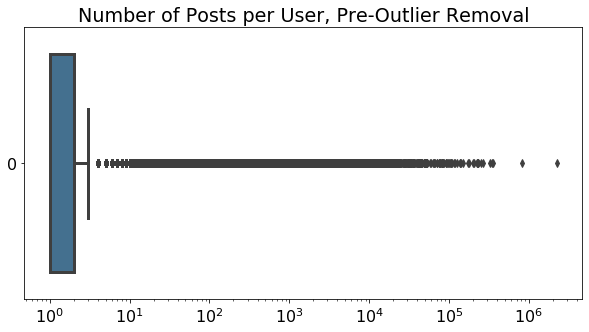

In [51]:
# check distribution of data, we see a high number of outliers which indicate strange behaviour

fig, ax = plt.subplots(figsize=(10, 5))
plt.rcParams.update({'font.size': 16})
sns.boxplot(data=df["posts"], orient='h', fliersize=5, linewidth=3,
            saturation=0.5, ax=ax)

ax.set_title('Number of Posts per User, Pre-Outlier Removal')
ax.set_xscale("log")
plt.show()

In [52]:
# we see there are a lot of bots included with these outliers which we will need to remove
df.sort_values(by = "posts", axis= 0, ascending= False)

,author,subreddit,posts
3993,3932,AutoNewspaper,2243748.000000
2848,2821,newsbotbot,819895.000000
4211710,2661946,TranscribersOfReddit,359610.000000
1702860,1321537,forexhome,345320.000000
2542328,1822605,removalbot,327779.000000
...,...,...,...
17058605,3681505,KotakuInAction,1.000000
17058604,5070668,BoJackHorseman,1.000000
17058603,3003823,BipolarSOs,1.000000
17058602,6964174,AskDocs,1.000000


In [53]:
df_mean = df["posts"].mean()
df_std = df["posts"].std()
df_outliers = df[df["posts"] > df_mean + (df_std * 4)]

In [54]:
df_outliers

,author,subreddit,posts
488,485,BakaNewsJP,2008.000000
540,537,IceCells,2560.000000
677,674,de,3326.000000
890,883,SteamTradingCards,5218.000000
1341,959,nsfw,2073.000000
...,...,...,...
38347910,11873591,u_dof42704,1957.000000
38348341,11873676,battlemaps,2487.000000
38348692,11046393,russianworldcup2018,2484.000000
38349636,5519691,AskRedditUL,2222.000000


In [55]:
# as a large number of posters significantly higher than the mean appear to be bots or marketers, dropping them from the dataset
df = df[df["posts"] < df_mean + (df_std * 4)].copy()

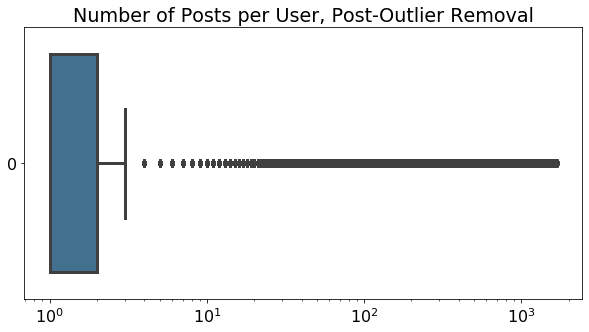

In [56]:
# after dropping outliers we see a more even distribution of data, though still a large number of outliers

fig, ax = plt.subplots(figsize=(10, 5))
plt.rcParams.update({'font.size': 16})
sns.boxplot(data=df["posts"], orient='h', fliersize=5, linewidth=3,
            saturation=0.5, ax=ax)

ax.set_title('Number of Posts per User, Post-Outlier Removal')

ax.set_xscale("log")
plt.show()

#### Understand Subreddit Usage per User
* Additionally, the majority of users only post to a small number of subreddits, any user who posts to less than 10 subreddits was dropped from the analyses


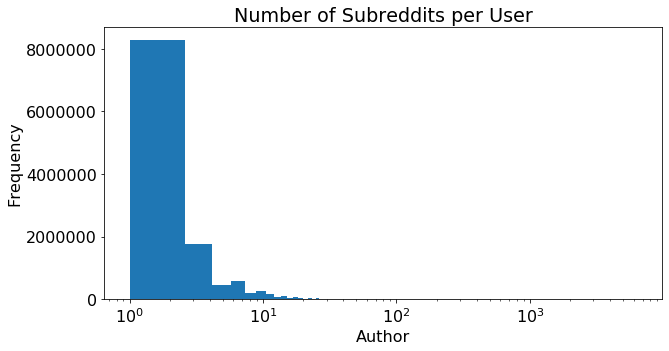

In [57]:
# log scale
fig, ax = plt.subplots(figsize=(10, 5))
plt.rcParams.update({'font.size': 16})
df["author"].value_counts().plot(kind='hist', bins=4000, title='Number of Subreddits per User')
plt.xlabel('Author')
plt.ylabel('Frequency')
ax.set_xscale("log")
plt.show()

In [58]:
#get dict of unique counts 
author_count = df["author"].value_counts().to_dict()

# add column for frequency of users
df["freq"] = [author_count[i] for i in df["author"]]


In [59]:
# drop users who have posted to less than 10 subreddits, will not be useful for analysis
df = df[df["freq"] > 9].copy()

# drop frequncy column
df.drop(labels = "freq", axis= 1, inplace= True)

# del author_count to save memory
del author_count

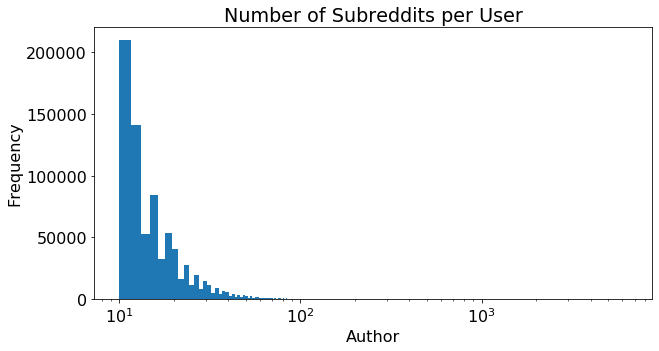

In [60]:
# log scale
fig, ax = plt.subplots(figsize=(10, 5))
plt.rcParams.update({'font.size': 16})
df["author"].value_counts().plot(kind='hist', bins=4000, title='Number of Subreddits per User')
plt.xlabel('Author')
plt.ylabel('Frequency')
ax.set_xscale("log")
plt.show()

#### Combine mental health related subreddits for target variable
* Create target variable
* Turn into boolean, 1 for posting to mental health subreddits

In [61]:
#target reddits identified from r/anxiety related subreddits
string= """/r/mentalhealth/r/Anxiety/r/SuicideWatch/r/bipolar/r/bipolarreddit/r/depression/r/detachmentdisorder/r/dpdr/r/GFD/r/MentalHealth/r/mentalillness/r/stopselfharm/r/Agoraphobia/r/anxietydepression/r/HealthAnxiety/r/socialanxiety/r/Anxietyhelp/r/selfharm/r/OCD/r/depression_help/r/AnxietyDepression/r/antidepressants"""
target_reddits = string.split("/r/")[1:]

In [62]:
#get list of unique subreddits
subreddits = df["subreddit"].unique()
len(subreddits)

369632

In [63]:
# group together target variable
df["subreddit"] = ["df_target" if i in target_reddits else i for i in df["subreddit"]]

df[df["subreddit"] == "df_target"]

,author,subreddit,posts
470,469,df_target,44.000000
1232,1224,df_target,10.000000
4581,4495,df_target,28.000000
5125,5021,df_target,16.000000
6300,6159,df_target,28.000000
...,...,...,...
40275600,3518907,df_target,6.000000
40276406,2486550,df_target,6.000000
40277455,6772860,df_target,6.000000
40278281,366944,df_target,6.000000


In [64]:
#turn to boolean for prediction
df.loc[df["subreddit"] == "df_target", ["posts"]] = 1 
df[df["subreddit"] == "df_target"]

,author,subreddit,posts
470,469,df_target,1.000000
1232,1224,df_target,1.000000
4581,4495,df_target,1.000000
5125,5021,df_target,1.000000
6300,6159,df_target,1.000000
...,...,...,...
40275600,3518907,df_target,1.000000
40276406,2486550,df_target,1.000000
40277455,6772860,df_target,1.000000
40278281,366944,df_target,1.000000


In [65]:
#check for duplicates, boolean now so can remove
df[df["subreddit"] == "df_target"].duplicated()

470         False
1232        False
4581        False
5125        False
6300        False
            ...  
40275600    False
40276406     True
40277455     True
40278281     True
40278719     True
Length: 56319, dtype: bool

In [66]:
df.drop_duplicates(inplace= True)

In [67]:
df[df["subreddit"] == "df_target"]

,author,subreddit,posts
470,469,df_target,1.000000
1232,1224,df_target,1.000000
4581,4495,df_target,1.000000
5125,5021,df_target,1.000000
6300,6159,df_target,1.000000
...,...,...,...
40262160,191693,df_target,1.000000
40271243,2268526,df_target,1.000000
40274874,2745368,df_target,1.000000
40275150,6065410,df_target,1.000000


#### Merge Tiny Subreddits
* High number of subreddits have less than 10 posters, often related to personal usernames, merging these into one feature 


In [68]:
# we see over 1 million subreddits which only have one user, merging these into "single_user_reddits"
single_df = df.groupby("subreddit").count()[df.groupby("subreddit").count()["author"] < 11]
single_df

,author,posts
subreddit,,
*polhold00214,1,1
000000000000O0000000,1,1
001,1,1
0010000010000011001,1,1
0011110000110011,2,2
...,...,...
zzz,1,1
zzzCOLDPIZZAzzz,1,1
zzzz,2,2


In [69]:
#create list of subreddits to merge
single_user_subreddits = single_df.index

In [70]:
# renaming single user subreddits to one variable
df["subreddit"] = ["single_user_subreddits" if i in single_user_subreddits else i for i in df["subreddit"]]



In [71]:
# file to take through for EDA & Feature Extraction
df.to_csv("/Users/samholt/GA/DSI12-lessons/projects/Capstone_Project/Capstone_MKII_DataFinal.csv'")